# TUTORIAL W36

In this tutorial, we will get acquainted with working with MEG data on UCloud  
We will be using the MNE-sample-data that contains visual and auditory stimulations  
The dataset also contains anatomical MR-data processed with FreeSurfer, meaning that we have access to a forward model linking the source space to sensor space.  
With that we can create an inverse model for reconstructing the sensor space visual and auditory responses in the source space.  
In this tutorial we will zoom through a lot of the steps, which throughout the course will be covered explicitly

## SETUP YOUR ENVIRONMENT

**Make sure that you have followed the instructions for setting up your environment, local and UCloud before beginning on this.** The instructions can be found here: https://github.com/ualsbombe/2025_advanced_cognitive_neuroscience/blob/main/README.md

## RESPECT EACH OTHER'S PERSONAL DATA

**Note** that 3D plots cannot be opened on UCloud (these are mostly (fancy) source space plots). That is why we also set up a local environment for you to create these plots. It is very important that you do **not** store any subject MR-data locally. Therefore, we will only plot on the *fsaverage* template brain (distributed with FreeSurfer). Single subjects can be morphed onto this template

In [2]:
## IMPORTS

import mne ## MNE-Python for analysing data
## below magic provides interactive plots in notebook
%matplotlib widget
from os import chdir
from os.path import join
import matplotlib.pyplot as plt ## for basic plotting
import matplotlib as mpl ## for setting default parameters

/home/lau/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
#%% SET DEFAULT PLOTTING PARAMETERS

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['lines.linewidth'] = 3

## SAMPLE DATA SET (https://mne.tools/stable/documentation/datasets.html#sample)
*These data were acquired with the Neuromag Vectorview system at MGH/HMS/MIT Athinoula A. Martinos Center Biomedical Imaging. EEG data from a 60-channel electrode cap was acquired simultaneously with the MEG. The original MRI data set was acquired with a Siemens 1.5 T Sonata scanner using an MPRAGE sequence.*

*In this experiment, checkerboard patterns were presented to the subject into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the face.*

Change the path to your relevant path below


In [4]:
#%% LOAD SAMPLE DATA SET

sample_path = '/work/MEG_data/MNE-sample-data' ## UCloud
sample_path = '/home/lau/mne_data/MNE-sample-data/' ## local
sample_meg_path = join(sample_path, 'MEG', 'sample')
chdir(sample_meg_path)
subjects_dir = '../../subjects/'

In [5]:
#%% READ RAW

raw_sample = mne.io.read_raw_fif('sample_audvis_raw.fif', preload=True)

Opening raw data file sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


In [ ]:
## PLOT RAW DATA
fig = raw_sample.plot()

In [ ]:
## COMPUTE POWER SPECTRAL DENSITY
psd = raw_sample.compute_psd() 

## INSPECT THE DATA

How do you tell that an online low-pass filter of 170 Hz has been applied?

In [ ]:
## PLOT POWER SPECTRAL DENSITY
fig = psd.plot() # online low-pass filter of 170 Hz

## FILTERING THE DATA

We low-pass filter the data, as we are only looking for evoked responses, which are rarely above 40 Hz

In [ ]:
## FILTERING DATA WITH LOW-PASS FILTER
raw_sample.filter(l_freq=None, h_freq=40); # low-pass filter of 40 Hz

In [ ]:
## PLOTTING POWER SPECTRAL DENSITY AFTER LOW-PASS FILTER
fig = raw_sample.compute_psd().plot()

## FINDING THE RELEVANT EVENTS

On the trigger channel `'STI014'`, square pulses were sent to indicate when stimuli were presented and responses were registered.
Check the `raw_sample.plot()` and see if you can find it and the square pulses

Finding events on: STI 014
320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


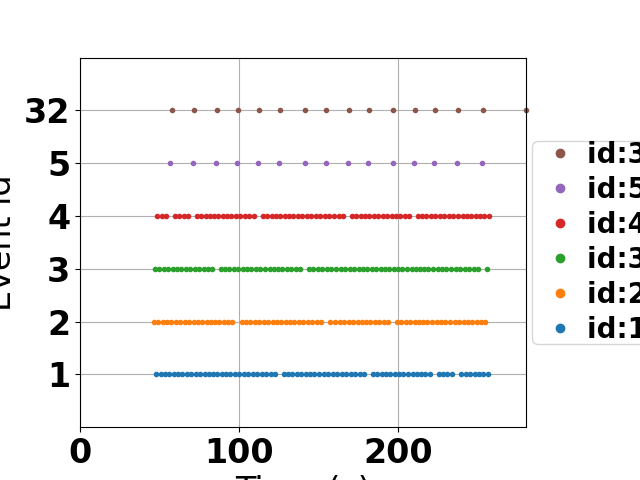

In [6]:
#%% FIND EVENTS

events_sample = mne.find_events(raw_sample)
mne.viz.plot_events(events_sample, sfreq=raw_sample.info['sfreq']);

## LA: 1: Response to left-ear auditory stimulus (a tone)
## RA: 2: Response to right-ear auditory stimulus
## LV: 3: Response to left visual field stimulus (checkerboard)
## RV: 4: Response to right visual field stimulus
## smiley: 5: Response to the smiley face
## button: 32: Response triggered by the button press
# https://mne.tools/stable/overview/datasets_index.html#sample

## SEGMENTING/EPOCHING THE DATA

Instead of handling all the data at once, we just cut out segments around the events of interest

In [7]:
#%% EPOCH THE DATA
event_id = dict(LA=1) ## we'll just look at this one event
tmin = -0.200 # s
tmax =  0.600 # s
baseline = (None, 0) # s (from beginning to 0); for demeaning

## segment the data
epochs_sample = mne.Epochs(raw_sample, events_sample,
                           event_id, tmin, tmax, baseline, preload=True)
epochs_sample.set_eeg_reference(projection=True);

Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 72 events and 481 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


In [ ]:
## PLOT EPOCHS
fig = epochs_sample.plot()

## AVERAGING TO OBTAIN AN EVOKED RESPONSE

To increase the signal-to-noise ratio, we average the epochs

In [ ]:
#%% AVERAGE (EVOKED)
evoked_sample = epochs_sample.average()

In [ ]:
## PLOTTING AVERAGES
evoked_sample.plot() 
mne.viz.plot_evoked_topo(evoked_sample);

In [ ]:
#%% HAVING MORE THAN ONE EVENT

event_id = dict(LA=1, RA=2, LV=3, RV=4)
more_epochs = mne.Epochs(raw_sample, events_sample,
                           event_id, tmin=-0.200, tmax=0.600,
                           baseline=(None, 0),
                           preload=True)

more_evokeds = list()
for event in more_epochs.event_id:
    more_evokeds.append(more_epochs[event].average());



In [ ]:
## PLOT SEVERAL EVENTS
mne.viz.plot_evoked_topo(more_evokeds);

## FORWARD MODEL

$\boldsymbol L (\boldsymbol r)$ is our forward model that for each source location $\boldsymbol r$, expresses how that source is linked to the sensors. The SI-unit is $\frac {T} {Am}$.  
The SI-unit for the magnetic field at each time point, $t$, $\boldsymbol b (t)$ is $T$.  
The SI-unit for the current density $\boldsymbol s(\boldsymbol r, t)$  at each location $\boldsymbol r$ and time point $t$ is $Am$.  
The forward model states for each source at whatever $\boldsymbol r$ how its activation in $Am$ is linked to the magnetic field at each sensor, e.g. $b_1(t)$.  
$\boldsymbol n(t)$ is the Gaussian noise at each time point

$\boldsymbol b(t) = \left[
\begin{array}{c} 
b_1(t) \\
b_2(t) \\
\vdots \\
b_M(t)
\end{array}
\right]$  
$\boldsymbol{b}(t) = \boldsymbol{L}(\boldsymbol{r}) \boldsymbol s(\boldsymbol r, t) + \boldsymbol n(t)$

The nice people from MNE-Python have already made a forward model for us

In [9]:
## READ FORWARD MODEL
fwd = mne.read_forward_solution('sample_audvis-meg-eeg-oct-6-fwd.fif')

Reading forward solution from /home/lau/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


## PLOTTING THE FORWARD MODEL

`mne.viz.plot_alignment` does not work on UCloud

In [ ]:
## PLOT SOURCE SPACE

# extract source space
src = fwd['src']
##plot alignment does not work on UCloud
mne.viz.plot_alignment(info=epochs_sample.info, src=src, subjects_dir='../../subjects/',
                       subject="sample", surfaces="white", trans='sample_audvis_raw-trans.fif')

## 2D alternative

#mne.viz.plot_sensors(raw_sample.info);

## CODE FOR GETTING INFO ABOUT THE ELEMENTS OF THE FORWARD MODEL

- `info` has information about the positions of the channels in the subject's head coordinate system; the origo is at the intersection of the pre-auricular points and the nasion. The first three elements in `'loc'` are the *xyz* coordinates
- `src` has info about where sources are placed, with the current model: on the surface of the cerebral cortex. There is also more information about the orientation of the sources.
- `trans` contains the transformation matrix that takes the subject's head space (defined in terms of a so-called Polhemus digitisation system) into the subject's MR space, effecitively bringing the sensor positions from `info` into the same coordinate system as the MR coordinate system.
- `bem_solution` contains information about how currents propagate through the three media, brain, skull and skin, to the electrodes and to the magnetometers and gradiometers. The entry in `[i, j]` indicates how much the potential, [*V*] changes in `i` when a unit current dipole (1 Am) is placed in `j`.


In [8]:
## INFO ABOUT WHERE CHANNELS ARE (in subject's head space)
info = epochs_sample.info
print(info['chs'][2]['loc'])

[-0.1066      0.0464     -0.0604     -0.0127      0.0057     -0.99990302
 -0.186801   -0.98240298 -0.0033     -0.98232698  0.18674099  0.013541  ]


In [ ]:
## INFO ABOUT WHERE SOURCES ARE (in subject's MR space)
src = fwd['src']
# src = mne.source_space.setup_source_space(subject='sample', subjects_dir=subjects_dir)
print(fwd['src'][0]['rr'])

In [ ]:
## TRANSFORMATION MATRIX THAT MAPS THE TWO SPACES ONTO ANOTHER
trans = mne.read_trans('sample_audvis_raw-trans.fif')
print(trans)

In [32]:
## BOUNDARY ELEMENT METHOD

## describe the surfaces and their conductivities
#bem_model = mne.bem.make_bem_model(subject=subject, subjects_dir=subjects_dir,
#                           conductivity=[0.3, 0.006, 0.3]) ## three layer model

## model how electrical potentials spread to the electrodes and how the 
# currents of the brain are related to the magnetic field measured at the
# sensors
#bem_solution = mne.bem.make_bem_solution(bem_model)

bem_solution = mne.bem.read_bem_solution('../../subjects/sample/bem/sample-5120-5120-5120-bem-sol.fif')

print(bem_solution['solution'])


Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /home/lau/mne_data/MNE-sample-data/MEG/sample/../../subjects/sample/bem/sample-5120-5120-5120-bem-sol.fif
[[ 2.1514516e-02 -1.8183291e-05 -1.6480033e-05 ... -5.9466978e-04
  -6.6832255e-04 -8.1568857e-04]
 [-1.1894640e-05  2.0677185e-02 -9.1299444e-06 ... -4.5286494e-04
  -3.5304064e-04 -4.2359543e-04]
 [-1.7444265e-05 -1.4329190e-05  2.0779889e-02 ... -3.9645983e-04
  -4.3777065e-04 -3.9654653e-04]
 ...
 [-7.9648926e-06  5.6645104e-07 -1.5632158e-06 ...  1.0602014e+00
   3.4819089e-02  3.0055961e-02]
 [-8.0139662e-06  3.6772704e-07 -1.5281699e-06 ...  3.3850696e-02
   1.0879593e+00  3.0417060e-02]
 [-8.5733745e-06  1.1546878e-09 -1.7350318e-06 ...  2.7086738e-02
   2.7894983e-02  1.1020797e+00]]


In [ ]:
## create a forward solution using four ingredients; L(r),
# which maps how sources in the brain link to sensors in the helmet:
# info: information about channel positions and sensor types
# trans: the transformation needed to align channel positions with MR
# src: the source model (in this case, a cortical sheet)
# bem_solution: modelling of how electrical currents spread toward the
#               electrodes   

#fwd = mne.make_forward_solution(info=info, trans=trans, src=src, bem=bem_solution)

## FINALLY DO THE MINIMUM NORM ESTIMATE

$$
\huge \hat{\boldsymbol \nu}_{vox}(t) = \boldsymbol L_V^T(\boldsymbol G + \epsilon \boldsymbol I)^{-1} \boldsymbol b(t)    
$$
with
$$
\huge \boldsymbol G = \int_\Omega \boldsymbol L (\boldsymbol r) \boldsymbol L^T (\boldsymbol r) d^3r
$$
and with
$$ 
\huge
\boldsymbol{\hat{\nu}}_{vox}(t) = \left[
\begin{array}{c} 
\boldsymbol{\hat s} (\boldsymbol r_1, t) \\
\boldsymbol{\hat s} (\boldsymbol r_2, t) \\
\vdots \\
\boldsymbol{\hat s} (\boldsymbol r_N, t)
\end{array}
\right]  
$$


In [ ]:
##  used to whiten the data, i.e. normalizing magnetometers, gradiometers
## and electrode readings to make them comparable
noise_cov = mne.compute_covariance(epochs_sample, tmin=None, tmax=0)
noise_cov.plot(raw_sample.info)

In [ ]:
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs_sample.info, fwd,
                                                          noise_cov)

# estimating the source pattern for each time point Vvox(t)
# right auditory stimulus (evokeds_sample[1])
MNE = mne.minimum_norm.apply_inverse(evoked_sample, inverse_operator,
                                     method='MNE')
## standard is to use method=dSPM for depth correction

In [ ]:
MNE.plot(subject='sample', subjects_dir=subjects_dir, hemi='both') ## can only be done locally

## EXTRA ASSIGNMENTS
- Compare the `'dSPM` method with the `'MNE'` method in `.apply_inverse()`. How do the source reconstructions differ?
- Do you see any sub-cortical or cerebellar sources? Why (not)?
- Plot the difference between conditions `'LA'` and `'RA'` on the source level - where are the main differences? To subtract two source time courses from one another you can use:
```
MNE_diff = MNE_LA.copy()
MNE_diff._data -= MNE_RA.data
```
- Also plot the difference between conditions `'LV'` and `'RV'`
- What sense can you make of `plt.imshow(bem_solution['solution'][:20, :20], clim=(0, 1e-4))`
